In [2]:
import mne
import numpy as np
from pathlib import Path

### Loading Data

In [10]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import mne

# Get the current file path
current_file_path = Path(os.path.abspath(""))

# Get the root path of the project
root_path = current_file_path.parents[0]

eeg_recordings_path = root_path / "eeg_recordings"
print(eeg_recordings_path)

/Users/anthonyricher/apps/neuro-clash/neuro_ai/eeg_recordings


In [29]:
# Load the csv data
df = pd.read_csv(eeg_recordings_path / "EEG_recording_test_raw.csv")
df.info()
print(df)

# Assuming the EEG data is in columns named 'TP9', 'AF7', 'AF8', 'TP10', 'Right AUX'
# Adjust these according to your CSV file's structure
ch_names = ["TP9", "AF7", "AF8", "TP10", "Right AUX"]
# Define channel types - assuming all channels are EEG
ch_types = ["eeg"] * len(ch_names)

# The first column is timestamps, which we don't need for the RawArray
eeg_data = df.iloc[:, 1:].T.values


# Create an MNE Info object (replace 256 with the actual sampling frequency)
info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)

# Create mne RawArray
raw = mne.io.RawArray(eeg_data, info)
# Save as FIF format
raw.save(eeg_recordings_path / "EEG_recording_test_raw.fif", overwrite=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85236 entries, 0 to 85235
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamps  85236 non-null  float64
 1   Unnamed: 1  85236 non-null  float64
 2   Unnamed: 2  85236 non-null  float64
 3   Unnamed: 3  85236 non-null  float64
 4   Unnamed: 4  85236 non-null  float64
 5   Unnamed: 5  85236 non-null  float64
dtypes: float64(6)
memory usage: 3.9 MB
        timestamps  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5
0      1131628.872     -22.949     109.863     -11.230     148.926    -221.191
1      1131628.876     -10.742     701.172      -2.930     795.898       1.953
2      1131628.879     -45.410    -140.625     -50.781    -556.152       7.812
3      1131628.883     -63.477    -764.160     -51.270   -1000.000      16.113
4      1131628.897     -36.621    -312.012     -18.066    -343.262      -2.441
...            ...         ...         ...        

### Filtering

Opening raw data file /Users/anthonyricher/apps/neuro-clash/neuro_ai/eeg_recordings/EEG_recording_test_raw.fif...
Isotrak not found
    Range : 0 ... 85235 =      0.000 ...   332.949 secs
Ready.
Reading 0 ... 85235  =      0.000 ...   332.949 secs...
Using matplotlib as 2D backend.


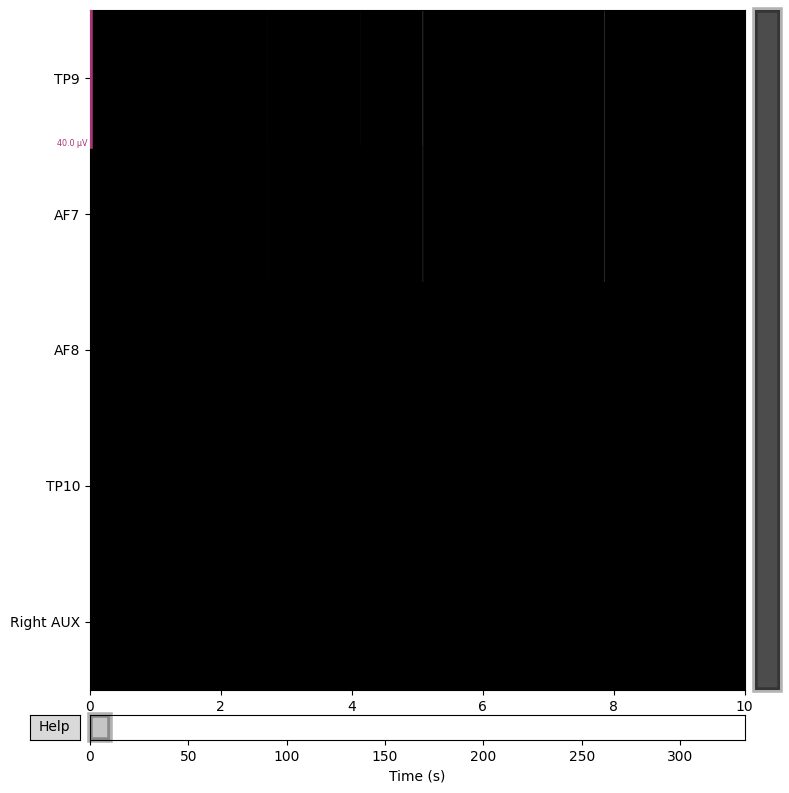

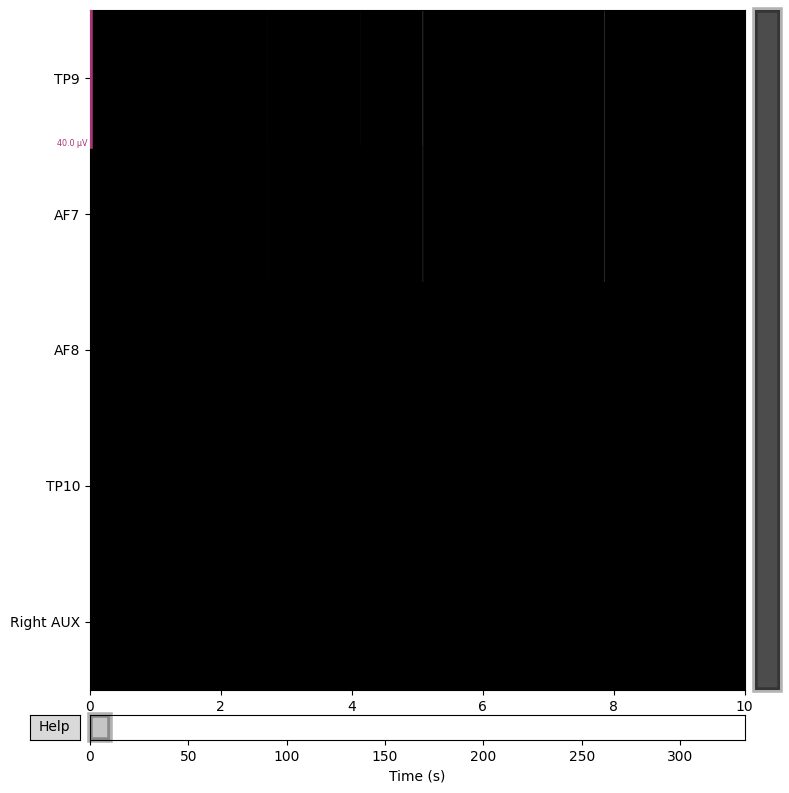

In [25]:
raw = mne.io.read_raw_fif(
    eeg_recordings_path / "EEG_recording_test_raw.fif", preload=True
)

# Remove frequency above 40 Hz
raw.plot(block=True, scalings="auto", lowpass=40, title="EEG recording")

# Optionally, apply a notch filter to remove power line noise at 50 Hz or 60 Hz
# raw.notch_filter(np.arange(50, 251, 50), filter_length="auto", phase="zero")

# Apply band-pass filter
# raw.filter(8, 30, method="iir")

### Remove Artifacts

In [ ]:
# Apply ICA for artifact removal
ica = mne.preprocessing.ICA(n_components=20, random_state=0)
ica.fit(raw)
raw = ica.apply(raw)

### Segment

In [ ]:
# Segment the data into epochs
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, event_id=1)

In [ ]:
# Normalize the data
epochs_data = epochs.get_data()
epochs_data_normalized = (epochs_data - np.mean(epochs_data)) / np.std(epochs_data)

# Feature extraction (example: spectral power in alpha band)
frequencies, power = mne.time_frequency.psd_welch(epochs, fmin=8, fmax=12)
alpha_power = np.sum(power, axis=-1)

# Downsample the data
epochs_resampled = epochs.copy().resample(100)  # resample to 100Hz